# Web Scrapping Github Repositories
In order to grasp a comprehensive scope of current status of all repositories under our lab, I built this brief web scraper to organize my workflow. The motivation for search selection is based on the need of each repo. To gauge the level of needs, I chose to parse out `the number of issues`. Additionally, `last updated dates` are also important to understand whether the repo is actively managed at this time.

Recent request from our lab was to generate a list of active PRs in NeuroData organization, thus further scrapping was conducted to extract `title of PR`, `PR's direct URL`, and `the author who made the initial PRs`. The output is exported as an excel spreadsheet, which was subsequently registered as a NeuroData github issue.

## Import packages

In [1]:
import urllib.request
import re
import pandas as pd
pd.options.display.max_rows = None
import matplotlib.pyplot as plt
import seaborn as sns

## Manually set the total number of repos under the organization

In [2]:
repo_count = 236 #number of repos

## Request url of each pages
Imported pages are `read()` as html after which it is decoded as a utf-8 format

In [3]:
total_page = 236//30 + 1 if 4%5 > 0 else 0
data = []
for i in range(1, total_page+1):
    tmp = urllib.request.urlopen(f'https://github.com/orgs/neurodata/repositories?page={i}')
    data.append(tmp.read().decode('utf-8'))
    print(tmp.url)

https://github.com/orgs/neurodata/repositories?page=1
https://github.com/orgs/neurodata/repositories?page=2
https://github.com/orgs/neurodata/repositories?page=3
https://github.com/orgs/neurodata/repositories?page=4
https://github.com/orgs/neurodata/repositories?page=5
https://github.com/orgs/neurodata/repositories?page=6
https://github.com/orgs/neurodata/repositories?page=7
https://github.com/orgs/neurodata/repositories?page=8


In [4]:
data[0][:1000]

'\n\n<!DOCTYPE html>\n<html lang="en" data-color-mode="auto" data-light-theme="light" data-dark-theme="dark">\n  <head>\n    <meta charset="utf-8">\n  <link rel="dns-prefetch" href="https://github.githubassets.com">\n  <link rel="dns-prefetch" href="https://avatars.githubusercontent.com">\n  <link rel="dns-prefetch" href="https://github-cloud.s3.amazonaws.com">\n  <link rel="dns-prefetch" href="https://user-images.githubusercontent.com/">\n  <link rel="preconnect" href="https://github.githubassets.com" crossorigin>\n  <link rel="preconnect" href="https://avatars.githubusercontent.com">\n\n\n\n  <link crossorigin="anonymous" media="all" integrity="sha512-E9wnWjoxQmh5A1jiWVYDPKOvA8VPf0iKQYoc+9ycMJvtAi9gOSlaUci+W2smxFIlWkV8hkX+O27S8NIB59iIDw==" rel="stylesheet" href="https://github.githubassets.com/assets/light-13dc275a3a314268790358e25956033c.css" /><link crossorigin="anonymous" media="all" integrity="sha512-nYSv3KrFhMlGUpjkFQBLMEN6HvHhijcoubQLjV3DWlcABEi2yDYf6KGUjRubJ5R+dJnKXR7jA4wu5Dg2

## Main body of the scraper

#### Get the issues and the last updated time

#### Get the list of PR

In [5]:
from datetime import datetime

In [6]:
datetime(2021,1,2) < datetime(2021,1,1)

False

In [7]:
dat = []
rl = 500 #read length

for d in data:
    exist = True

    while exist:
        exist = re.search('/neurodata/.*/issues', d)

        if not exist:
            break

        #get the name and the number of issues
        idx = re.search('href="/neurodata/.*/issues', d).span()
        key = d[idx[0]:idx[1]]
        tmp = d[idx[0]:idx[0]+rl]
        word = '\n</a>\n'
        tmp_loc = tmp.find(word)
        tmp_dat = [re.split('/', key)[2], int(tmp[tmp_loc-3:tmp_loc])]

        #get the number of last update
        tmp = d[idx[0]:idx[0]+rl*10]
        word = '<relative-time datetime="'
        tmp_loc = tmp.find(word)
        l = tmp_loc+len(word)
        tmp_dat.append(tmp[l:l+10])

        #get number of PR
        idx2 = re.search('href="/neurodata/.*/pull', d).span()
        key = d[idx2[0]:idx2[1]]
        tmp = d[idx2[0]:idx2[0]+rl+500]
        word = '\n</a>\n'
        tmp_loc = tmp.find(word)
        tmp_dat.append(int(tmp[tmp_loc-3:tmp_loc]))

        #access PR page
        pr_tmp = urllib.request.urlopen(f'https://github.com/neurodata/{tmp_dat[0]}/pulls')
        pr_data = pr_tmp.read().decode('utf-8')
        
        #parse PR page
        pr_exist = True

        while pr_exist:
            pr_url = f'/neurodata/{tmp_dat[0]}/pull'
            print(pr_url)
            try:
                #extract pr title and pr url
                pr_idx = re.search(f'hovercard" href="{pr_url}/.*"', pr_data).span()
                pr_url = pr_data[pr_idx[0]+17:pr_idx[1]-1]
                pr_url2 = 'https://github.com/' + pr_url
                pr_tmp = pr_data[pr_idx[0]:pr_idx[0]+rl]
                pr_fword = pr_url + '">'
                pr_lword = '</a>\n'
                tmp_floc = pr_tmp.find(pr_fword)
                tmp_floc += len(pr_fword)
                tmp_lloc = pr_tmp.find(pr_lword)
                new_tmp_dat = tmp_dat.copy() + [pr_url2, pr_tmp[tmp_floc:tmp_lloc]]

                #extract pr authors
                pr_key = 'title="Open pull requests created by '
                pr_idx_auth = re.search(pr_key, pr_data).span()[0] + len(pr_key)
                pr_doc = pr_data[pr_idx_auth:pr_idx_auth+30]
                pr_lword = '" '
                tmp_lloc = pr_doc.find(pr_lword)
                new_tmp_dat += [pr_doc[:tmp_lloc]]

                pr_data = pr_data[pr_idx[0]+rl:]
                dat.append(new_tmp_dat)
            except:
                pr_exist = False

        d = d[idx[0]+rl:]

    #prevents too many url request error
    if int(new_tmp_dat[2][:4]) < 2020:
        break

/neurodata/scikit-learn/pull
/neurodata/scikit-learn/pull
/neurodata/scikit-learn/pull
/neurodata/scikit-learn/pull
/neurodata/partition_decode/pull
/neurodata/ProgLearn/pull
/neurodata/ProgLearn/pull
/neurodata/ProgLearn/pull
/neurodata/ProgLearn/pull
/neurodata/ProgLearn/pull
/neurodata/ProgLearn/pull
/neurodata/ProgLearn/pull
/neurodata/ProgLearn/pull
/neurodata/ProgLearn/pull
/neurodata/ProgLearn/pull
/neurodata/ProgLearn/pull
/neurodata/df-dn-paper/pull
/neurodata/df-dn-paper/pull
/neurodata/df-dn-paper/pull
/neurodata/hyppo/pull
/neurodata/hyppo/pull
/neurodata/hyppo/pull
/neurodata/SDTF/pull
/neurodata/SDTF/pull
/neurodata/graph-stats-book/pull
/neurodata/graphbook-code/pull
/neurodata/brainlit/pull
/neurodata/brainlit/pull
/neurodata/brainlit/pull
/neurodata/brainlit/pull
/neurodata/brainlit/pull
/neurodata/brainlit/pull
/neurodata/neurodata.io/pull
/neurodata/kdg/pull
/neurodata/kdg/pull
/neurodata/talks/pull
/neurodata/talks/pull
/neurodata/bilateral-connectome/pull
/neurodat

## Checking to make sure we've collected all repos

In [8]:
len(dat), dat[:2]

(59,
 [['scikit-learn',
   5,
   '2021-12-22',
   3,
   'https://github.com//neurodata/scikit-learn/pull/11',
   '[TEST PR] Adding oblique trees (i.e. Forest-RC) to cythonized tree module',
   'adam2392'],
  ['scikit-learn',
   5,
   '2021-12-22',
   3,
   'https://github.com//neurodata/scikit-learn/pull/10',
   '[TEST PR] Oblique forests',
   'adam2392']])

## Save nested lists as a tabulated form for data wrangling

In [9]:
df = pd.DataFrame(data=dat, columns=['Repository', 'Issues', 'Last Update', 'PR-count', 'PR-url', 'PR-title', 'Lead'])
df.head(20)

,Repository,Issues,Last Update,PR-count,PR-url,PR-title,Lead
0,scikit-learn,5,2021-12-22,3,https://github.com//neurodata/scikit-learn/pul...,[TEST PR] Adding oblique trees (i.e. Forest-RC...,adam2392
1,scikit-learn,5,2021-12-22,3,https://github.com//neurodata/scikit-learn/pul...,[TEST PR] Oblique forests,adam2392
2,scikit-learn,5,2021-12-22,3,https://github.com//neurodata/scikit-learn/pull/8,Tom/grid to graph 26,adam2392
3,ProgLearn,42,2021-12-22,10,https://github.com//neurodata/ProgLearn/pull/528,Added streaming capability for ODIN,LizaNaydanova
4,ProgLearn,42,2021-12-22,10,https://github.com//neurodata/ProgLearn/pull/527,Added neural network scene segmentation tutorial.,LizaNaydanova
5,ProgLearn,42,2021-12-22,10,https://github.com//neurodata/ProgLearn/pull/526,Add Streaming Function,KhelmholtzR
6,ProgLearn,42,2021-12-22,10,https://github.com//neurodata/ProgLearn/pull/522,unsupervised contrastive loss,KevinWang905
7,ProgLearn,42,2021-12-22,10,https://github.com//neurodata/ProgLearn/pull/518,Supervised Contrastive Loss,Dante-Basile
8,ProgLearn,42,2021-12-22,10,https://github.com//neurodata/ProgLearn/pull/517,Exploring task unaware vs aware BTE and genera...,waleeattia
9,ProgLearn,42,2021-12-22,10,https://github.com//neurodata/ProgLearn/pull/464,Add notebook &amp; functions for adversarial d...,kfenggg


## Change dtype of date as datetime

In [10]:
df['Last Update'] = pd.to_datetime(df['Last Update'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Repository   59 non-null     object        
 1   Issues       59 non-null     int64         
 2   Last Update  59 non-null     datetime64[ns]
 3   PR-count     59 non-null     int64         
 4   PR-url       59 non-null     object        
 5   PR-title     59 non-null     object        
 6   Lead         59 non-null     object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 3.4+ KB


## Visualization of the first 30 repos

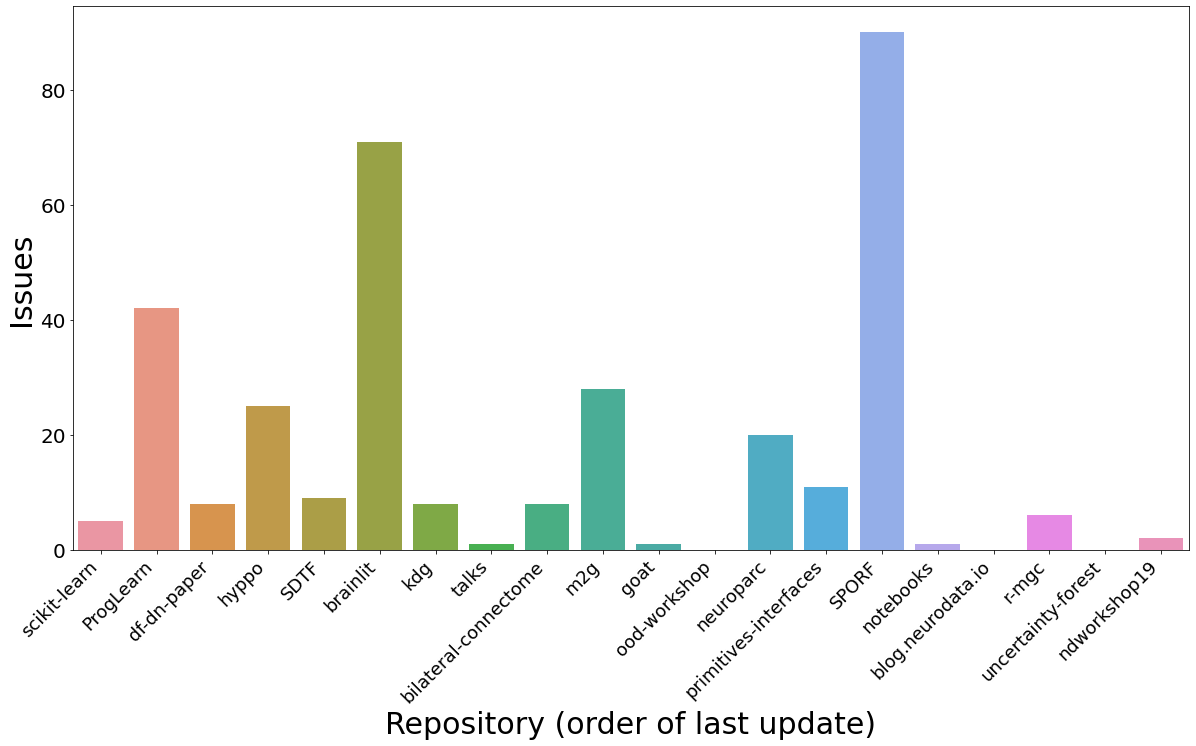

In [11]:
xlabel = 'Repository'
ylabel = 'Issues'

fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.barplot(data=df, x=xlabel, y=ylabel, ax=ax)
ax.set_xticklabels(labels=df['Repository'].unique(), rotation=45, ha='right', fontsize=18);
ax.set_xlabel(xlabel=xlabel+' (order of last update)', fontsize=30);
ax.set_ylabel(ylabel=ylabel, fontsize=30);
plt.yticks(fontsize=20);
plt.savefig('./fig/output-b4-filtering.jpg', bbox_inches='tight')

## Filter data
1. Nubmer of Issues > 0
2. Last Updated Date is no earlier than `2021-09-01`

In [12]:
sorted_df = df.sort_values(by='Issues', ascending=False)
sorted_df = sorted_df.sort_values(by=['Last Update', 'Issues', 'Repository'], ascending=False)
sorted_df = sorted_df.query('Issues > 0')
sorted_df = sorted_df[sorted_df['Last Update'] > '2021-09-01']
sorted_df.head(20)

,Repository,Issues,Last Update,PR-count,PR-url,PR-title,Lead
3,ProgLearn,42,2021-12-22,10,https://github.com//neurodata/ProgLearn/pull/528,Added streaming capability for ODIN,LizaNaydanova
10,ProgLearn,42,2021-12-22,10,https://github.com//neurodata/ProgLearn/pull/463,Adding KNNClassificationDecider,tliu68
8,ProgLearn,42,2021-12-22,10,https://github.com//neurodata/ProgLearn/pull/517,Exploring task unaware vs aware BTE and genera...,waleeattia
7,ProgLearn,42,2021-12-22,10,https://github.com//neurodata/ProgLearn/pull/518,Supervised Contrastive Loss,Dante-Basile
5,ProgLearn,42,2021-12-22,10,https://github.com//neurodata/ProgLearn/pull/526,Add Streaming Function,KhelmholtzR
4,ProgLearn,42,2021-12-22,10,https://github.com//neurodata/ProgLearn/pull/527,Added neural network scene segmentation tutorial.,LizaNaydanova
9,ProgLearn,42,2021-12-22,10,https://github.com//neurodata/ProgLearn/pull/464,Add notebook &amp; functions for adversarial d...,kfenggg
6,ProgLearn,42,2021-12-22,10,https://github.com//neurodata/ProgLearn/pull/522,unsupervised contrastive loss,KevinWang905
11,ProgLearn,42,2021-12-22,10,https://github.com//neurodata/ProgLearn/pull/454,Draft of SPORF,latasianguy
12,ProgLearn,42,2021-12-22,10,https://github.com//neurodata/ProgLearn/pull/453,UF enhanced parameters to match GRF,parthgvora


## Visualization after filtering

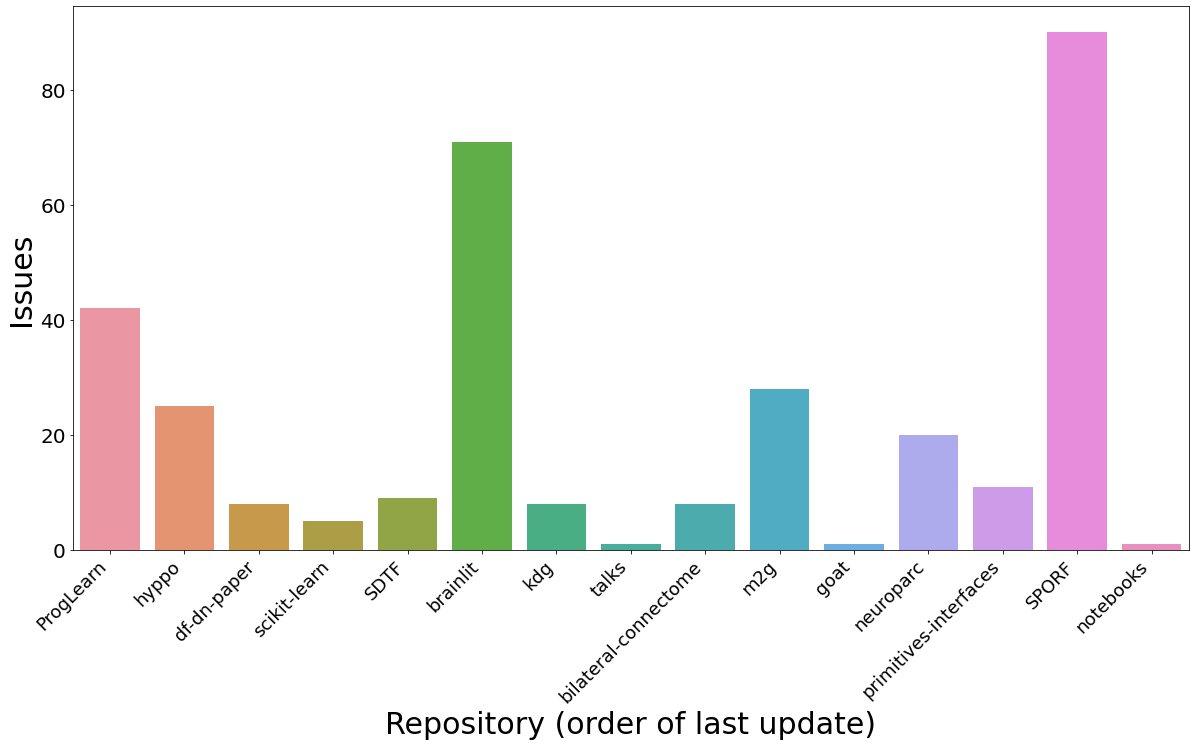

In [13]:
xlabel = 'Repository'
ylabel = 'Issues'

fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.barplot(data=sorted_df, x=xlabel, y=ylabel, ax=ax)
ax.set_xticklabels(labels=sorted_df['Repository'].unique(), rotation=45, ha='right', fontsize=18);
ax.set_xlabel(xlabel=xlabel+' (order of last update)', fontsize=30);
ax.set_ylabel(ylabel=ylabel, fontsize=30);
plt.yticks(fontsize=20);
plt.savefig('./fig/output.jpg', bbox_inches='tight')

## Excel Export of Active PR list

In [14]:
df2 = df[df['Last Update'] > '2021-09-01'][['PR-title', 'PR-url', 'Last Update', 'Repository','Lead']]
df2['Last Update'] = df2['Last Update'].astype(str)
df2.columns = ['PR Name', 'PR Url', 'Last Update', 'Repository', 'Lead']
df2 = df2[['Lead', 'Repository', 'PR Name', 'PR Url']]

df2.head()

,Lead,Repository,PR Name,PR Url
0,adam2392,scikit-learn,[TEST PR] Adding oblique trees (i.e. Forest-RC...,https://github.com//neurodata/scikit-learn/pul...
1,adam2392,scikit-learn,[TEST PR] Oblique forests,https://github.com//neurodata/scikit-learn/pul...
2,adam2392,scikit-learn,Tom/grid to graph 26,https://github.com//neurodata/scikit-learn/pull/8
3,LizaNaydanova,ProgLearn,Added streaming capability for ODIN,https://github.com//neurodata/ProgLearn/pull/528
4,LizaNaydanova,ProgLearn,Added neural network scene segmentation tutorial.,https://github.com//neurodata/ProgLearn/pull/527


In [15]:
df2.to_excel('NeuroData_PR_list.xlsx', index=False)